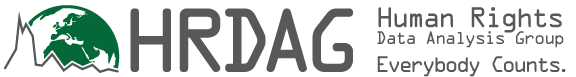

In [2]:
from IPython.display import Image
Image(filename='data/banner.png')

# Table of Contents
- [Using large language models for structured information extraction from the Innocence Project New Orleans' wrongful conviction case files](#using-large-language-models-for-structured-information-extraction-from-the-ipno-case-files)
  - [Introduction](#introduction)
  - [Structured data extraction with regular expressions](#structured-data-extraction-with-regex)
  - [Structured data extraction with a large language model](#structured-data-extraction-with-an-llm)
- [Evaluations, issues, improvements](#evaluations-issues-improvements)
- [Future research/next steps](#future-researchnext-steps)
  - [Fine-tuning](#fine-tuning)
- [Appendix](#appendix)
  - [Testing with GPT-4](#gpt-4-evaluation)
  - [Acknowledgements](#acknowledgements)

<a id="using-large-language-models-for-structured-information-extraction-from-the-ipno-case-files"></a>
# Using large language models for structured information extraction from the Innocence Project New Orleans' wrongful conviction case files

- [Ayyub Ibrahim](https://ip-no.org/who-we-are/staff/#ai), Director of Research for LLEAD, Innocence Project of New Orleans
- [Tarak Shah](https://hrdag.org/people/tarak-shah/), Data Scientist, Human Rights Data Analysis Group

<a id="introduction"></a>
# Introduction

Exoneration documents, documents acquired during the legal processes that seek to rectify miscarriages of justice, offer invaluable insights into wrongful conviction cases. Particularly, they illuminate the roles and actions of law enforcement personnel. Yet, the sheer volume and lack of structure in these documents pose challenges for researchers, lawyers, and advocates dedicated to transparency and justice. In 2022, the Innocence Project New Orleans (IPNO) launched the Louisiana [Law Enforcement Accountability Database (LLEAD)](https://llead.co/), a consolidation of data from over 500 law enforcement agencies in Louisiana. To date, LLEAD hosts details of over 40,000 allegations of misconduct spanning 194 agencies across 48 of Louisiana's 64 parishes. This initiative is the first state-wide database of its kind. LLEAD is already an essential tool for exoneration work, and including wrongful conviction information in the database would make it even more useful. For example in Orleans Parish, Louisiana, 78% of wrongful convictions have been linked to law enforcement's failure to share exculpatory evidence with the defense, a rate more than double the national average. Given this backdrop, we seek to make these collections searchable and useful for lawyers, advocates, and community members to better investigate patterns of police misconduct and corruption. In order to do so, we rely on a multi-stage process:


1. Metadata Compilation: We started by compiling a comprehensive CSV index. This structured approach forms the foundation of our file management system, enabling file retrieval and basic deduplication. The metadata we organize in this step includes:

    - file path and name
    - file type
    - sha1 content hash: we truncate this to create unique file identifiers
    - file size and number of pages
    - case ID: when we scanned the documents, we organized them into directories organized by case ID, here we pluck and validate the directory name to add a structured case id field to our metadata index.

2) Page classification: The documents in the collection are varied, representing all documents produced or acquired in the course of an exoneration case, with case timelines going back decades. After some internal review and discussions with the Innocence Project New Orleans (IPNO) case management team, we narrowed our focus to three types of documents:
    - police reports: include mentions of officers involved in the arrest that led to the wrongful conviction, or related arrests
    - transcripts: court transcripts, recorded by clerks of the court, where officers appear as witnesses and describe their role in the conviction (including making the arrest, transporting evidence, interrogating the accused).
    - testimonies: witness testimony, which will include testimony from officers involved in the conviction
    
    Page classification involves building a classification model to categorize files (or page sequences within files) into these different types of documents. One approach is to fine-tune a pretrained convolutional neural network to label thumbnail images of document pages. Using thumbnails is advantageous because they are smaller files, resulting in faster processing and reduced computational resource consumption. This makes them an effective approach for retrieving specific types of documents from disorganized collections, as described in [*Evaluation of Deep Convolutional Nets for Document Image Classification and Retrieval*](https://arxiv.org/abs/1502.07058). In order to use this technique, we needed training data and a pretrained model. To quickly assemble a training data set for our page classifier, we started by noticing that in many cases the file name indicated the document type. These documents were scanned by many people at different times, so we could not rely on this heuristic for comprehensive categorization of documents, but there was more than enough there to jumpstart our training process. We collected our initial training data by probing filenames for specific search terms, and reviewing and confirming that we had inferred the correct document types from the filenames. Once we had training data, we used [FastAI](https://docs.fast.ai/) to fine-tune the `ResNet34` architecture, pretrained on [ImageNet](https://www.image-net.org/), to identify reports, transcripts, and testimonies based on page thumbnails. With the trained classifier, we were able to measure generalization performance on documents that couldn't be classified via filename, and we were also better able to target additional training data, for example by reviewing pages where the classifier had low confidence about its prediction. 

3) Information Extraction: Currently, we're engaged in extracting structured information from the documents we've identified, and that work is the focus of the current post. Our goal is to extract structured information related to each police officer or prosecutor mentioned in the documents, such as their names, ranks, and roles in the wrongful conviction.

4) Deduplication: The previous step leaves us with many distinct mentions, but some individuals are mentioned many times, within the same case or across cases. Here we rely on HRDAG's [extensive experience with database deduplication](https://hrdag.org/tech-notes/adaptive-blocking-writeup-1.html) to create a unique index of officers and prosecutors involved in wrongful convictions, and a record and the role or roles they had in the wrongful conviction.

5) Cross-referencing: In the final stage, we'll cross-reference the officer names and roles we've extracted with the Louisiana Law Enforcement Accountability Database [(LLEAD.co)](https://llead.co/). This stage will assist us in identifying other individuals linked with the implicated officers, such as their partners, those co-accused in misconduct complaints, or those co-involved in use-of-force incidents. The list of officers associated with previous wrongful conviction cases can then be cross-referenced with the IPNO's internal data on potential wrongful convictions with the aim of uncovering new instances of wrongful convictions.

In [5]:
import pandas as pd
def read_index():
    summary = pd.read_csv("data/index.csv")
    print("Index: Rows, Index: Columns")
    print(summary.shape)
    summary = summary.head(5)
    return summary

read_index()

Index: Rows, Index: Columns
(308770, 8)


,filepath,filename,filehash,filesize,uid,filetype,case_id,png
0,../input/wrongful-convictions-docs/BRIGHT_Dan_...,"Bright, Dan compensation check August 2013.pdf",2c1ba05aacf163c83319401f905a20287ddad5e6,182755,2c1ba05a,pdf,BRIGHT_Dan_302392,output/2c/1b/2c1ba05a_p0001.png
1,../input/wrongful-convictions-docs/BRIGHT_Dan_...,"Bright, Dan supplemental compensation appln (f...",f51f6b34d66366770b0993f297f2dcc06d161b5f,500097,f51f6b34,pdf,BRIGHT_Dan_302392,output/f5/1f/f51f6b34_p0001.png
2,../input/wrongful-convictions-docs/BRIGHT_Dan_...,"Bright, Dan supplemental compensation appln (f...",f51f6b34d66366770b0993f297f2dcc06d161b5f,500097,f51f6b34,pdf,BRIGHT_Dan_302392,output/f5/1f/f51f6b34_p0002.png
3,../input/wrongful-convictions-docs/BRIGHT_Dan_...,"Bright, Dan supplemental compensation appln (f...",f51f6b34d66366770b0993f297f2dcc06d161b5f,500097,f51f6b34,pdf,BRIGHT_Dan_302392,output/f5/1f/f51f6b34_p0003.png
4,../input/wrongful-convictions-docs/BRIGHT_Dan_...,"Bright, Dan supplemental compensation appln (f...",f51f6b34d66366770b0993f297f2dcc06d161b5f,500097,f51f6b34,pdf,BRIGHT_Dan_302392,output/f5/1f/f51f6b34_p0004.png


<a id="structured-data-extraction-with-regex"></a>
# Structured Data Extraction with Regex

A primary task in our process is extracting officer information from documents – specifically, the officer's name and the role the officer played in the wrongful conviction. The extraction of such information is crucial for understanding the dynamics and potential lapses that led to the conviction. Given the importance of this task, it's essential to approach it with a methodology that ensures accuracy and comprehensiveness.

We initially considered a regex-based solution for this extraction task. Regular expressions, or regexes, are powerful tools for pattern matching within text. However, as we delved deeper into our data, we realized that the complexity and variability of the content rendered regex less than ideal. While regex excels at identifying specific patterns within text, it often struggles with variations in language and nuances that commonly appear in natural language texts, such as police reports and court transcripts.

Consider the text string from a court transcript reading, "Sergeant Ruiz was mentioned as being involved in the joint investigation with Detective Martin Venezia regarding the Seafood City burglary and the murder of Kathy Ulfers." Such a sentence poses challenges for regex due to its inability to capture semantic context. Without understanding the broader narrative, regex cannot infer that Sergeant Ruiz acted as a lead detective in Kathy Ulfers' murder case.

To further highlight the limitations of regex in handling such tasks, we designed a simple baseline model. Instead of attempting to capture the full scope of officer information extraction, this model focuses solely on extracting officer names as a starting point. This choice was intentional; by narrowing down the task, we hoped to provide a clear example of the strengths and weaknesses of regex in the context of real-world data.

In [ ]:
pattern = re.compile(r"(detective|sergeant|lieutenant|captain|corporal|deputy|criminalist|technician|investigator"
                     r"|det\.|sgt\.|lt\.|cpt\.|cpl\.|dty\.|tech\.|dr\.)\s+([A-Z][A-Za-z]*(\s[A-Z][A-Za-z]*)?)", re.IGNORECASE)

After implementing our baseline model, we tested its performance on two different sets of data: police reports and court transcripts.

**Police Reports Results:**
- **Precision**: 0.845
This indicates that among the instances our model predicted as officer names, 84.5% of them were indeed officer names. A high precision suggests that the model is quite reliable in its positive predictions.
- **Recall**: 0.518
This metric reveals that our model was able to identify only 51.8% of the actual officer names present in the police reports. A lower recall signifies that while our predictions are accurate, we are missing out on a significant number of true officer names.
- **F1 Score**: 0.614
The F1 score harmonizes precision and recall, giving us a balanced view of the model's performance. At 0.614, it suggests that there is room for improvement, especially in capturing more true positives without sacrificing precision.
- **F_beta**: 0.549
This score is another harmonic mean of precision and recall but gives more weight to recall. A score of 0.549 further emphasizes the model's challenges in identifying all true positives.

**Court Transcripts Results:**
- **Precision**: 0.8656
Similar to the police reports, our model displayed high precision on court transcripts, indicating its reliability in positive predictions.
- **Recall**: 0.4281
However, the recall is notably lower on the court transcripts, meaning our model missed out on more than half of the actual officer names present in these documents.
- **F1 Score**: 0.5461
The F1 score for court transcripts is lower than that for police reports, suggesting a more pronounced trade-off between precision and recall in this dataset.
- **F_beta**: 0.4663
Once again, the F_beta score underscores the need for improving recall without compromising precision.

While our regex-based baseline model exhibits high precision on both datasets, it struggles notably with recall. This indicates that while the names it identifies as officers are likely correct, it misses a substantial number of actual officer names present in the documents. These findings further emphasize the challenges of using regex alone for such a complex task and underscore the need for more advanced techniques that can capture the nuances and variations in language.

<a id="structured-data-extraction-with-an-llm"></a>
# Structured Data Extraction with an LLM

An alternative approach is to prompt a generative language model with the document text along with a query describing our required output. One challenge with this approach is that the documents we're processing may be hundreds of pages long, whereas generative models have a limit to the length of the prompt you supply. We needed a way to pull out of each document just the chunks of text where the relevant officer information appears, to provide a more helpful prompt.

We split up the problem into two steps, identifying the relevant chunks of text content, and then extracting structured officer information from those chunks. We use [Langchain](https://docs.langchain.com/docs/), a natural language processing library, to manage this pipeline, and use OpenAI's language model, GPT-3-Turbo-16k as the language model powering the pipeline. 

For the first step, identifying the relevant chunks of text within the larger document, we used the approach outlined in [Precise Zero-Shot Dense Retrieval without Relevance Labels](https://arxiv.org/abs/2212.10496). This approach splits our information retrieval task into multiple steps:

1. We feed our query asking for names and roles of mentioned officers to an instruction-following generative language model, instructing it to compose a "hypothetical" document in response to the query.
2. We embed the hypothetical document
3. We chunk the document text into overlapping chunks, and calculate embeddings for each chunk using the same embedding system we used for the hypothetical document
4. We use [Faiss](https://faiss.ai/) to do similarity search, using similarity to our hypothetical document embeddings to identify chunks of relevant text content.

Here is the method we use to generate hypothetical embeddings. The resulting object can be used to embed chunks of text, enabling efficient similarity search over them.

In [21]:
PROMPT_TEMPLATE_HYDE = PromptTemplate(
    input_variables=["question"],
    template="""
    You're an AI assistant specializing in criminal justice research. 
    Your main focus is on identifying the names and providing detailed context of mention for each law enforcement personnel. 
    This includes police officers, detectives, deupties, lieutenants, sergeants, captains, technicians, coroners, investigators, patrolman, and criminalists, 
    as described in court transcripts.
    Be aware that the titles "Detective" and "Officer" might be used interchangeably.
    Be aware that the titles "Technician" and "Tech" might be used interchangeably.

    Question: {question}

    Roles and Responses:""",
)


def generate_hypothetical_embeddings():
    llm = OpenAI()
    prompt = PROMPT_TEMPLATE_HYDE

    llm_chain = LLMChain(llm=llm, prompt=prompt)

    base_embeddings = OpenAIEmbeddings()

    embeddings = HypotheticalDocumentEmbedder(
        llm_chain=llm_chain, base_embeddings=base_embeddings
    )
    return embeddings

The `process_single_document` function converts an input document into a vector database of chunks. This function employs Langchain's RecursiveCharacterTextSplitter to split documents into chunks of 500 tokens, while maintaining an overlap of 250 tokens to ensure contextual continuity.

There are times when the model might inadvertently identify names without clear ties to law enforcement personnel. By cross-referencing the model's output with LLEAD, we believe we will be able to filter out many such false positives (it's worth noting that some law enforcement personnel mentioned in the documents will be absent from LLEAD, but our current focus is on officers we can track using LLEAD). On the other hand, we have no way of recovering officer mentions if they are not picked up by our extraction process. In light of this, when evaluating the model we are more interested in maximizing recall, ensuring we identify as many genuine law enforcement mentions as we can.  To quantify this focus on recall, we employed the [F-beta score](https://en.wikipedia.org/wiki/F-score#F%CE%B2_score) (with β=2), which weighs recall twice as heavily as precision. We tested the model using varying chunk sizes, including 2000, 1000, and 500, with corresponding overlaps of 1000, 500, and 250 respectively. Based on our evaluations, the optimal configuration is a chunk size of 500 with an overlap of 250. After segmentation, the text is transformed into a high-dimensional space using precomputed embeddings from our hypothetical document embedder. The FAISS.from_documents function aids in this transformation, constructing an indexed document database designed for similarity searches.

In [22]:
def process_single_document(file_path, embeddings):
    logger.info(f"Processing document: {file_path}")

    loader = JSONLoader(file_path)
    text = loader.load()
    logger.info(f"Text loaded from document: {file_path}")

    text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=250)
    docs = text_splitter.split_documents(text)

    db = FAISS.from_documents(docs, embeddings)
    return db

In the following sections, we define the core function get_response_from_query(db, query). This function serves as the backbone of our information extraction process, taking in a document database and a query, and returning the system's response to the query. 

The process begins by setting up the relevant parameters. We use a prompt template to guide the query and a role template to define the roles we're interested in. We set the temperature parameter to 0 to maximize the determinism of our responses. The k parameter is set to 20, a decision guided by the F-beta score results from our testing phase, instructing the system to select and concatenate the top 20 relevant text chunks from the document corpus. These documents are then sorted by similarity score to maximize the model's performance. As suggested in the paper [Lost in the Middle: How Language Models Use Long Contexts](https://arxiv.org/abs/2307.03172), for retrieval tasks current language models perform best when the relevant data is located at the beginning of their context window.

The relevant chunks of text are then passed to the LLMChain class of the LangChain module as part of the 'run' method. In addition to relevant chunks, the 'run' method also receives the PromptTemplate, RoleTemplate, and the original query.

The LLMChain processes these inputs and generates a structured response to the initial query.

In [ ]:
PROMPT_TEMPLATE_MODEL = PromptTemplate(
    input_variables=["roles" ,"question", "docs"],
    template="""
    As an AI assistant, my role is to meticulously analyze court transcripts, traditional officer roles, and extract information about law enforcement personnel.

    Query: {question}

    Transcripts: {docs}

    Roles: {roles}

    The response will contain:

    1) The name of a officer, detective, deputy, lieutenant, 
       sergeant, captain, officer, coroner, investigator, criminalist, patrolman, or technician - 
       if an individual's name is not associated with one of these titles they do not work in law enforcement.
       Please prefix the name with "Officer Name: ". 
       For example, "Officer Name: John Smith".

    2) If available, provide an in-depth description of the context of their mention. 
       If the context induces ambiguity regarding the individual's employment in law enforcement, 
       remove the individual.
       Please prefix this information with "Officer Context: ". 

    3) Review the context to discern the role of the officer.
       Please prefix this information with "Officer Role: "
       For example, the column "Officer Role: Lead Detective" will be filled with a value of 1 for officer's who were the lead detective.
""",
)

ROLE_TEMPLATE = """
US-IPNO-Exonerations: Model Evaluation Guide 
Roles:
Lead Detective
•	Coordinates with other detectives and law enforcement officers on the case.
•	Liaises with the prosecutor's office, contributing to legal strategy and court proceedings.

Crime Lab Analyst:
•  Analyses various types of evidence gathered during an investigation, including but not limited to, DNA, fingerprints, blood samples, drug substances, etc.
•  Prepares detailed reports outlining the findings of their analyses.
"""

def get_response_from_query(db, query):
    # Set up the parameters
    prompt = PROMPT_TEMPLATE_MODEL
    roles = ROLE_TEMPLATE
    temperature = 0
    k = 20

    # Perform the similarity search
    doc_list = db.similarity_search_with_score(query, k=k)

    # Sort documents by relevance scores. Place documents with the highest relevance 

    docs = sorted(doc_list, key=lambda x: x[1], reverse=True)

    third = len(docs) // 3

    highest_third = docs[:third]
    middle_third = docs[third:2*third]
    lowest_third = docs[2*third:]

    highest_third = sorted(highest_third, key=lambda x: x[1], reverse=True)
    middle_third = sorted(middle_third, key=lambda x: x[1], reverse=True)
    lowest_third = sorted(lowest_third, key=lambda x: x[1], reverse=True)

    docs = highest_third + lowest_third + middle_third

    docs_page_content = " ".join([d[0].page_content for d in docs])

    # Create an instance of the OpenAI model
    llm = ChatOpenAI(model_name="gpt-3.5-turbo")

    # Create an instance of the LLMChain
    chain = LLMChain(llm=llm, prompt=prompt)

    # Run the LLMChain and print the response
    response = chain.run(roles=roles, question=query, docs=docs_page_content, temperature=temperature)
    print(response)

    # Return the response and the documents
    return response

For additional context, see the following inputs and outputs:

**Query**

"Identify individuals, by name, with the specific titles of officers, sergeants, lieutenants, captains, detectives, homicide officers, and crime lab personnel in the transcript. Specifically, provide the context of their mention related to key events in the case, if available."

**Relevant Document**

(1 of 20 documents identified by the Faiss similarity search as relevant)
 
 Martin Venezia, New Orleans police sergeant. A 16 .01 Sergeant Venezia, where are you assigned now? : - A Second Police District. 13 . And in October, September of 1979 and in Q 19 September and October of 1980, where were you assigned? :1 Homicide division. A. And how long have you been on the police department right now? Thirteen and a half years. A Officer Venezia, when did you or did you ever take over the investigation of ... Cathy Ulfers' murder? A", metadata={'source': '../../data/convictions/transcripts/iterative\\(C) Det. Martin Venezia Testimony - Trial One.docx'

**Response from the Model** 

Officer Name: Sergeant Martin Venezia

Officer Context: Sergeant Martin Venezia, formerly assigned to the Homicide Division, took over the investigation of Cather Ulfers murder.

Officer Role: Lead Detective 

<a id="evaluations-issues-improvements"></a>
# Evaluations, issues, improvements

In our effort to optimize the model's capability to extract officer names from documents, we evaluated it on various parameters. The following tests were run using GPT-4.

**Preprocessing Parameters**:

- Chunk Size: Defines the number of consecutive words or units of text processed at once.
- Chunk Overlap: This parameter dictates the number of words consecutive chunks share. For example, with an overlap of 250, the subsequent chunk begins 250 words into the previous chunk.

**Model-specific Parameters**:

- Hypothetical Document Embeddings (HYDE): Investigated their effect on the model's overall performance.
- 'k' Value: Denotes the number of text chunks input to the model.
- Temperature Parameter: Influences the randomness of the model.

For evaluating our model's performance, we utilized the F-beta score as our primary metric. Unlike the F1 score, which gives equal weight to precision (correctness) and recall (completeness), the F-beta score allows for differential weighting. We designed our score to weigh recall twice as much as precision, reflecting the importance of accurately spotting relevant information, even if it means occasionally flagging some irrelevant content.

Based on our evaluations, our model performed best with:
- A chunk size of 500
- A chunk overlap of 250
- Incorporating HYDE embeddings
- A 'k' value of 20

For police reports, the F-beta score reached 0.864909, while for transcripts, the F-beta score peaked at 0.813397.

Although larger chunk sizes, such as 1000 and 2000, might offer advantages for certain applications, they resulted in lower F-beta scores during our tests. Similarly, greater overlaps like 500 and 1000 reduced our performance, even with the potential for more context. The consistent advantage of incorporating HYDE embeddings was evident, underscoring their value to our model.

Another key observation was regarding the temperature parameter, which influences the model's level of randomness. With a temperature set to 1, we generally saw higher F-beta scores, especially for identifying officer names in police reports. As we move to the next phase — extracting detailed context about the officers role within the document — the precise handling of this parameter will be crucial because a high temperature can potentially skew results or generate "hallucinated" content.

In [26]:
def read_summary():
    summary = pd.read_excel("data/overall-summary-with-F1-Fbeta.xlsx")
    summary = summary.sort_values("F_beta", ascending=False)
    return summary

read_summary()

,chunk_size,chunk_overlap,temperature,k,hyde,filetype,FN,FP,TP,n_files,precision,recall,F1,F_beta
4,500,250,1,20,1,police-report,20,2,105,5,0.981308,0.840000,0.905172,0.864909
2,2000,1000,1,5,0,police-report,12,32,71,5,0.689320,0.855422,0.763441,0.816092
0,500,250,1,20,1,transcript,3,27,34,4,0.557377,0.918919,0.693878,0.813397
1,500,250,0,20,1,police-report,6,56,60,5,0.517241,0.909091,0.659341,0.789474
8,2000,1000,0,5,0,police-report,15,13,54,5,0.805970,0.782609,0.794118,0.787172
3,2000,1000,1,5,1,transcript,3,11,17,3,0.607143,0.850000,0.708333,0.787037
6,1000,500,0,10,1,transcript,15,31,57,6,0.647727,0.791667,0.712500,0.757979
10,2000,1000,0,5,1,transcript,22,18,60,7,0.769231,0.731707,0.750000,0.738916
7,2000,1000,0,5,1,police-report,13,37,49,5,0.569767,0.790323,0.662162,0.733533
12,1000,500,1,10,1,police-report,34,10,78,5,0.886364,0.696429,0.780000,0.727612


After our evaluation of the model based on various parameters, the next phase delved into understanding the model's behavior over iterative runs. Due to the stochastic nature of generative text models, a single document can yield diverse outputs when processed multiple times using the same parameters. This highlighted the challenge of identifying an optimal number of iterations, a balance that ensures comprehensive insights while being cost efficient. In the interest of cost efficiency, the following tests were run using GPT-3.5-Turbo-16K. The decline in performance can be attributed to the change in model. 

To address this, we employed two distinct query strategies:

Multiple Queries Approach: This strategy used six unique queries, each crafted to extract specific facets of the required information. The queries are as follows:

- Query 1: Identify individuals, by name, with the specific titles of officers, sergeants, lieutenants, captains, detectives, homicide officers, and crime lab personnel in the transcript. Specifically, provide the context of their mention related to key events in the case, if available.

- Query 2: List individuals, by name, directly titled as officers, sergeants, lieutenants, captains, detectives, homicide units, and crime lab personnel mentioned in the transcript. Provide the context of their mention in terms of any significant decisions they made or actions they took.

- Query 3: Locate individuals, by name, directly referred to as officers, sergeants, lieutenants, captains, detectives, homicide units, and crime lab personnel in the 
transcript. Explain the context of their mention in relation to their interactions with other individuals in the case."

- Query 4: Highlight individuals, by name, directly titled as officers, sergeants, lieutenants, captains, detectives, homicide units, and crime lab personnel in the transcript. Describe the context of their mention, specifically noting any roles or responsibilities they held in the case.

- Query 5: Outline individuals, by name, directly identified as officers, sergeants, lieutenants, captains, detectives, homicide units, and crime lab personnel in the transcript. Specify the context of their mention in terms of any noteworthy outcomes or results they achieved.

- Query 6: Pinpoint individuals, by name, directly labeled as officers, sergeants, lieutenants, captains, detectives, homicide units, and crime lab personnel in the transcript. Provide the context of their mention, particularly emphasizing any significant incidents or episodes they were involved in.

Singular Query Approach: This method employed a comprehensive query, designed to holistically capture all the desired information facets. We run the document through the same query repeatedly, which results in slightly different responses each time, and then collect the results together. The query is:

- Query: Identify each individual in the transcript, by name, who are directly referred to as officers, sergeants, lieutenants, captains, detectives, homicide officers, and crime lab personnel. Provide the context of their mention, focusing on key events, significant decisions or actions they made, interactions with other individuals, roles or responsibilities they held, noteworthy outcomes or results they achieved, and any significant incidents or episodes they were involved in, if available.


In the context of police reports, a detailed analysis of the singular query method showed that its performance metrics improved with each iteration up to the 4th iteration, with a marked increase in the F1 Beta score after each iteration. However, past this iteration, the incremental gains in the score reduced, indicating we had hit the point of diminishing returns.

<div style="text-align:center">
    <img src="https://github.com/ayyubibrahimi/llm-criminal-justice-research/assets/57520778/5eb5aff0-26b9-4fab-934b-9dbd5195b626" alt="Figure 1: Average Cumulative F1 Beta Score for 1 Query vs. 6 Queries (Police Reports)" width="600">
</div>


The analysis of court transcripts, on the other hand, offered a nuanced perspective. Both the singular and the 6 queries methods exhibited an upward trend in their performance metrics up until the 6th iteration.

<div style="text-align:center">
    <img src="https://github.com/ayyubibrahimi/llm-criminal-justice-research/assets/57520778/bc5e49c7-b510-40e1-a410-2c2372b3928e" alt="Figure 2: Average Cumulative F1 Beta Score for 1 Query vs. 6 Queries (Transcripts)" width="600">
</div>


Analyzing the results from both police reports and court transcripts gave us confidence in the singular query method. It consistently demonstrated a balance between performance and computational/cost demands, with diminishing performance gains beyond the 4th iteration in both datasets. Therefore, based on this analysis, the singular query strategy was selected for deployment over 4 iterations for all types of documents. 

<a id="fine-tuning"></a>
# Fine-tuning

Currently, GPT-4's pricing is 0.03 per 1K tokens for inputs and 0.06 per 1K tokens for outputs. In contrast, GPT-3-Turbo-4K is priced at 0.0015 per 1K tokens for inputs and 0.002 per 1K tokens for outputs. This means using GPT-4 is 19x and 29x more expensive, respectively. Given these cost considerations, coupled with challenges our existing GPT-3.5-Turbo-16K model faced in extracting officer details from documents in our FAISS similarity database, we've pivoted our focus towards the GPT-3.5-Turbo-4K model. While the GPT-3.5-Turbo-4K itself isn't new, the capability to fine-tune it was introduced by OpenAI in August 2023, offering a promising avenue for improvement.

In order to address our model's shortcomings, we found ways to efficiently generate additional training data. Using document samples, we extracted details about individual law enforcement officers, their contexts, and roles. Recognizing the potential of GPT-4, we leveraged its capabilities to craft training documents that closely resembled our real-world challenges. We provided GPT-4 with sample documents based on authentic data, enabling it to produce outputs with the stylistic nuances we often encounter—like poor OCR quality, fragmented sentences, inconsistent capitalization, and syntactic inconsistencies.

Here's an example of the training data we generated using GPT-4:

{ 
    
"messages": 

[{ "role": "system", "content": 
- "As an AI assistant, my role is to meticulously analyze criminal justice documents and extract information about law enforcement personnel. The response will contain: 1) The name of a law enforcement personnel. The individual's name must be prefixed with one of the following titles to be in law enforcement: Detective, Sergeant, Lieutenant, Captain, Deputy, Officer, Patrol Officer, Criminalist, Technician, Coroner, or Dr. Please prefix the name with 'Officer Name:  I will derive this data from the following paragraph: On September 13, DET. X. Y. Allen responded to claims of counterfeit money circulating in the Westside Market. Primary informants were Mrs. Jacobs, a vendor, and Mr. Silva, a customer. FORWARD COPY TO: DETECTIVE DIVISION. INFORMANT DOCS."}, 

{ "role": "user", "content": 
- 'Identify each individual in the transcript, by name, who are directly referred to as officers, sergeants, lieutenants, captains, detectives, homicide officers, and crime lab personnel." }, 

{ "role": "assistant", "content": 
- "Officer Name: DET. X. Y. Allen
- Officer Context: On September 13, DET. X. Y. Allen responded to claims of counterfeit money circulating in the Westside Market. 
- Officer Role: Detective" }] 

}

In our fine-tuning experiments, we worked with four dataset sizes: 25, 50, 75, and 100 examples. Analyzing the outcomes, a clear trend emerged: as we increased the dataset size, the model's performance improved incrementally. Even with the constraints of the 4k token limit, which led us to adjust our K parameter from 25 to 15, our model exhibited differentiated performance across document types. It surpassed the GPT-3.5-Turbo-16k model when processing court transcripts and matched its efficiency for police reports. However, as promising as these strides are, they haven't yet reached the capabilities of GPT-4 (See appendix for GPT-4 results).

<div style="text-align:center">
    <img src="https://github.com/ayyubibrahimi/llm-criminal-justice-research/assets/57520778/c0f108c5-c202-4887-ba77-997b1e6575dd" alt="Figure 3: Average Cumulative F1 Beta Score for 1 Query vs. 6 Queries (Police Reports) - Model: GPT-3" width="600">
</div>


<div style="text-align:center">
    <img src="https://github.com/ayyubibrahimi/llm-criminal-justice-research/assets/57520778/90a78aab-f358-4947-aa82-43f95dea568e" alt="Figure 4: Average Cumulative F1 Beta Score for 1 Query vs. 6 Queries (Court Transcripts) - Model: GPT-3" width="600">
</div>

The results from our current fine-tuning experiments with GPT models provide valuable insights into the potential and limitations of AI in data extraction tasks. Our observations underscore the significance of dataset size and quality, as well as the implications of token constraints on model performance. As we move forward:

We will delve deeper into the interplay between token limits and extraction accuracy, particularly in documents with varying complexities.
We'll further investigate the optimal balance between training data volume and model efficiency, exploring potential diminishing returns or inflection points.
Given the differentiated performance across document types, our research will also focus on domain-specific fine-tuning to optimize extraction from court transcripts, police reports, and other legal documents.



# Complex Tree of Thought Methodology and Its Integration with Fine-Tuned GPT-3-Turbo

The Tree of Thought methodology, as implemented in our work, stands as a structured approach to problem-solving within the realms of AI and machine learning. This methodology aligns with the natural cognitive process of humans, where complex tasks are broken down into simpler, more manageable components. Such an approach is especially effective in parsing and processing extensive and intricate queries often encountered in legal and technical domains.

In large language models (LLMs), like GPT-3-Turbo, the Tree of Thought methodology plays a pivotal role. It allows for the segmentation of complex queries into smaller, distinct elements, enabling the model to address each part with increased focus and precision. This leads to more accurate and comprehensive responses, a crucial factor in fields requiring detailed and precise information extraction.

Building on Fine-Tuning GPT-3-Turbo
Our approach takes a significant step forward by building on the fine-tuned GPT-3-Turbo. Fine-tuning this advanced model has enabled us to tailor its capabilities to our specific requirements, particularly in the context of legal document analysis. Fine-tuning involves adjusting the model on a dataset that is representative of the specific tasks it will perform, allowing it to understand and process queries with a higher degree of accuracy and relevance to the given context.

By integrating the Tree of Thought methodology with a fine-tuned GPT-3-Turbo, we have achieved several key advancements:

- Enhanced Precision and Relevance: The fine-tuned model is more adept at handling the nuances of legal language and the specificities of complex queries, leading to outputs that are highly relevant and precise.

- Improved Problem Decomposition: The fine-tuning allows the model to better decompose complex queries into manageable segments, aligning with the Tree of Thought approach for systematic problem-solving.

- Adaptive Query Processing: The model can adaptively process each segment of a query, considering the unique aspects and requirements of each part, thereby improving the overall quality and applicability of the responses.

In summary, the integration of the Tree of Thought methodology with fine-tuned GPT-3-Turbo marks a significant leap in our ability to effectively process and analyze complex queries in legal document analysis. This combination harnesses the strengths of both advanced model tuning and structured problem-solving approaches, setting a new standard in the field of AI-driven legal analysis.

**Application in Document Relevance Evaluation**

In the realm of legal document analysis, the application of the Tree of Thought methodology significantly enhances the model's capability to evaluate document relevance. This process begins with the LLM assessing the overall relevance of a set of documents to a given query. Instead of attempting to process the entire query and all documents in one go, the methodology advocates for a staggered approach. Each document is examined in the context of specific query elements, allowing the model to meticulously analyze and score its relevance. This granular approach to relevance evaluation not only increases the precision of the model but also enables it to handle complex legal language and concepts more effectively. The scoring system, based on a scale of 1-10, provides a quantitative measure of relevance, assisting in the objective assessment of each document's utility in answering the query.

In [ ]:

def evaluate_document_relevance(llm, docs, query, threshold):
    template = """
    Documents: {docs}
    Query: {query}
    
    As an AI assistant, your task is to evaluate the relevance and quality of the documents with respect to their ability to provide an answer to the query. 
   
    Provide a score on a scale from 1-10. 
    Povide one score, for all the documents, in the following format: 
    
    confidence_score: (score)

    Only provide the score with the prefix "confidence_score: "
    """
    prompt = PromptTemplate(input_variables=["docs", "query"], template=template)
    chain = LLMChain(llm=llm, prompt=prompt, output_key="confidence_score")
    result = chain.run(docs=docs, query=query, temperature=0)

    if ':' in result:
        result_dict = {"confidence_score": float(result.split(":")[1].strip())}
    else:
        try:
            result_dict = {"confidence_score": float(result.strip())}
        except ValueError:
            # Handle the case where the result is not a float
            logging.warning(f"Could not convert result to a float: {result}")
            result_dict = {"confidence_score": 0}
        # print(f"Query: {query}, Result: {result}")

    try:
        confidence_score = int(result_dict["confidence_score"])
    except ValueError:
        logging.warning(
            f"Could not convert confidence score to an integer: {result_dict['confidence_score']}"
        )
        confidence_score = 0

    better_query_needed = confidence_score < threshold

    return {
        "confidence_score": confidence_score,
        "better_query_needed": better_query_needed,
    }


**Query Refinement**

The query refinement process is where the Tree of Thought methodology truly shines. Post the initial evaluation of documents, the model employs feedback mechanisms to iteratively refine the query. If the confidence score of the documents’ relevance falls below a predetermined threshold, the model enters a refinement loop. In this stage, it re-examines the query in light of the documents' content, identifying areas where the query could be more specific or aligned with the information available in the documents. This iterative process ensures that the refined query is more targeted and likely to yield relevant documents. By continually adjusting the query based on the documents' analysis, the model adapts to the intricacies and nuances of legal language, enhancing its efficiency and accuracy in document retrieval and information extraction. The refined query is then used in subsequent searches within the database, exemplifying a dynamic and responsive approach to legal document analysis.

In [ ]:
def generate_better_query(llm, original_query, docs, threshold):
    # Template for generating a better query
    template = """
    Transcripts: {docs}
    The original query: {original_query} did not yield satisfactory results with a confidence below {threshold}.
    Please provide a new and improved query that we can send to the faiss vector database for document retrival.
    The new query must aim to answer the {original_query}
    A:
    """

    prompt = PromptTemplate(
        input_variables=["original_query", "docs", "threshold"], template=template
    )
    chain = LLMChain(llm=llm, prompt=prompt, output_key="better_query")
    result = chain.run(
        original_query=original_query, docs=docs, threshold=threshold, temperature=0
    )
    if result:
        better_query = result
    else:
        logging.warning("Result is empty. Using original query instead.")
        better_query = original_query
    return better_query


**Brainstorming Stage: Strategy Development**

The brainstorming stage in your model plays a crucial role in developing comprehensive strategies for extracting data from law enforcement documents. This stage involves generating multiple strategic approaches for parsing the documents to identify all law enforcement personnel mentioned, along with their contexts and roles. The Large Language Model (LLM) is prompted to brainstorm three distinct strategies, ensuring each one aims to minimize ambiguity and maximizes the accuracy and comprehensiveness of the extracted information.

This process is not just about generating potential solutions; it's about creatively leveraging the unique content and context within the documents. The model considers the specific nuances of the text, such as the way officers are referred to, the nature of their involvement in events, and how their roles are described. This approach enables the model to tailor its strategies to the specific characteristics of the dataset, ensuring that the information extraction is as relevant and accurate as possible.

**Chaining Outputs for Enhanced Analysis**

Once the brainstorming stage is complete, the model enters a critical phase where it chains the outputs of various stages to refine its analysis further. This is done in several steps:

Evaluating Brainstormed Strategies: The model evaluates the brainstormed strategies for their relevance and effectiveness in answering the query. It assigns a confidence score to each strategy, providing a quantitative measure of its potential utility.

Selecting the Best Strategy: Based on the confidence scores, the model selects the most promising strategy. This strategy is then used to guide the subsequent data extraction process. The selection is made by comparing the confidence scores and choosing the one with the highest rating.

Data Extraction Based on Selected Strategy: The model uses the chosen strategy to extract detailed information about law enforcement personnel from the documents. It identifies each officer, provides context for their mention, and discerns their specific roles.

Re-evaluation for Comprehensive Extraction: Finally, the model re-evaluates the documents to identify any law enforcement personnel it might have missed in the first iteration. This step ensures that the extraction is exhaustive and no relevant information is overlooked.

Through these stages, your model demonstrates an advanced level of reasoning and adaptability. It not only devises multiple strategies for tackling a complex task but also intelligently selects the most suitable one based on its potential effectiveness. This methodical and iterative approach enhances the model's accuracy and reliability in extracting and analyzing data from intricate legal documents, ensuring a thorough and nuanced understanding of the content.

In [ ]:
def get_indepth_response_from_query(
    db,
    query,
    TEMPERATURE,
    k,
    max_iterations=1,
):
    logger.info("Performing in-depth summary query...")

    tuned_model = "ft:gpt-3.5-turbo-1106:personal::8IOkEZB9"

    llm = tuned_model

    iteration_counter_db = 0
    confidence_rating_db = 0
    threshold_db = 7

    ## Stage 1: Query refinement stage. Task: evaluate the relevance of docs returned from vector db with respect to query
    best_query = refine_query(db, llm, query, k, threshold_db, sort_retrived_documents)
    # print(f"BEST QUERY: {best_query}")
    docs, docs_page_content, page_numbers = get_response_from_query(db, best_query, 1, k)

    # print(best_query_vector)

    ## Helper funcs
    def execute_brainstorming_stage(docs):
        template1 = """
            Documents: {docs}
            Question: {question}

            The primary objective is to extract comprehensive data on each and every law enforcement personnel mentioned in the documents provided. This includes their names, the context of their mentions, and their roles within the law enforcement agency.

            Brainstorm three distinct strategies that meticulously leverage the specific content and context of these documents to accurately extract the names, context mentions, and roles of all law enforcement personnel mentioned. Each strategy should aim at minimizing ambiguity and ensuring a comprehensive extraction of information.

            Please provide the output in the following format:
            1. Strategy One:
            2. Strategy Two: 
            3. Strategy Three:

            A:
            """
        prompt1 = PromptTemplate(
            input_variables=["question", "docs"], template=template1
        )
        chain1 = LLMChain(llm=llm, prompt=prompt1, output_key="angles")
        responses_llm = chain1.run(question=best_query, docs=docs, temperature=1)
        parsed_angles = parse_angles(responses_llm)
        return parsed_angles

    def evaluate_output(angles, docs, angle_confidence_dict):
        template1_evaluation = """
            Transcripts: {docs}
            Query: {question}
            Based on the brainstormed angles: {angles}, rate your confidence in the quality and relevance of these perspectives for answering the query 
            on a scale of 1 to 10. Only return the confidence score.
            A:
            """
        prompt1_evaluation = PromptTemplate(
            input_variables=["question", "docs", "angles"],
            template=template1_evaluation,
        )
        chain1_evaluation = LLMChain(
            llm=llm, prompt=prompt1_evaluation, output_key="confidence_rating"
        )

        for angle, content in angles.items():
            result = chain1_evaluation.run(
                question=best_query, docs=docs, angles=content, temperature=0
            )
            print(f"Angle: {angle}, Result: {result}")

            if isinstance(result, (int, float)):
                confidence_rating = result
            elif isinstance(result, str):
                try:
                    confidence_rating = float(result.strip())
                except ValueError:
                    confidence_rating = 0
            else:
                confidence_rating = 0

            angle_confidence_dict[content] = confidence_rating

        # Check if any angle has a confidence score
        if not angle_confidence_dict or all(
            v == 0 for v in angle_confidence_dict.values()
        ):
            logging.warning(
                "No angles were evaluated or all angles have zero confidence. Returning the first angle."
            )
            best_angle = list(angles.keys())[0]  # Get the first angle
            return {"best_angle": best_angle, "confidence_rating": 0}

        # Sorting the dictionary by values. In case of a tie, the first item with the maximum value will be chosen.
        best_angle = max(angle_confidence_dict, key=angle_confidence_dict.get)
        print(f"Best Angle: {best_angle}")

        return {
            "best_angle": best_angle,
            "confidence_rating": angle_confidence_dict[best_angle],
            "angle_confidence_dict": angle_confidence_dict,
        }

    ### Stage 2: Evaluate angles returned. Choose the best angle.

    threshold_brainstorm = 7
    iteration_counter_brainstorm = 0
    confidence_rating_brainstorm = 0

    angle_confidence_dict = {}
    while (
        confidence_rating_brainstorm < threshold_brainstorm
        and iteration_counter_brainstorm < max_iterations
    ):
        logging.info("Brainstorming function invoked.")
        angles_dict = execute_brainstorming_stage(docs_page_content)
        response = evaluate_output(angles_dict, docs, angle_confidence_dict)
        confidence_rating_brainstorm = int(response.get("confidence_rating", 0))
        angle_confidence_dict.update(
            response.get("angle_confidence_dict", {})
        )  # Cumulatively updating the dictionary

        iteration_counter_brainstorm += 1
        logging.info(
            f"Iteration: {iteration_counter_brainstorm}, Confidence Rating: {confidence_rating_brainstorm}"
        )

    if iteration_counter_brainstorm == max_iterations:
        logging.warning(
            f"Maximum number of iterations ({max_iterations}) reached without crossing the confidence threshold. Brainstorm func will no longer be re-run."
        )

    best_angle = max(angle_confidence_dict, key=angle_confidence_dict.get)
    print(f"Best Angle: {best_angle}")

    # Stage 3: Extract Data
    template2 = """
    Question: {question}

    Documents: {docs}

    Approach to answering query: {angle}

    As an AI assistant, my role is to identify each law enforcement officer named in the documents. 

    For each officer I identify, my response will contain:

    The name of a law enforcement personnel. The individual's name must be prefixed with one of the following titles to be in law enforcement: 
        Detective, Sergeant, Lieutenant, Captain, Deputy, Officer, Patrol Officer, Criminalist, Technician, Coroner, or Dr. 
        Please prefix the name with "Officer Name: ". 
        For example, "Officer Name: John Smith".

    Provide an in-depth description of the context of their mention. 
        If the context induces ambiguity regarding the individual's employment in law enforcement, please make this clear in your response.
        Please prefix this information with "Officer Context: ". If the context is not available, still include the officer.

    Review the context to discern the role of the officer. For example, Lead Detective (Homicide Division), Supervising Officer (Crime Lab), Detective, Officer on Scene, Arresting Officer, Crime Lab Analyst
        Please prefix this information with "Officer Role: "
        For example, "Officer Role: Lead Detective". If the role is not available, still include the officer.
        """

    prompt2 = PromptTemplate(
        input_variables=["question", "docs", "angle"], template=template2
    )
    chain2 = LLMChain(llm=llm, prompt=prompt2)
    response2 = chain2.run(
        question=query, docs=docs_page_content, angle=best_angle, temperature=0
    )
    
    # Stage 4 - Re-evaluate
    template3 = """
        Documents: {docs}
        Previously extracted law personnel: {first_iteration}
        Current task: Re-evaluate to identify law enforcement personnel that you did not extract.

        As an AI assistant, my role is to identify each law enforcement officer named in the documents. The individual's name must be prefixed with one of the following titles to be in law enforcement: 
        Detective, Sergeant, Lieutenant, Captain, Deputy, Officer, Patrol Officer, Criminalist, Technician, Coroner, or Dr. 

        This iteration will include both the previously extracted law personnel and the newly extracted personnel.

        Here are examples of how the data should be formatted.
        
        Officer Name: Detective Venezia
        Officer Context: After completing interviews, Sergeant Ruiz and Detective Venezia decided to separately review the information gathered to date and meet again on the following day to choose the next course of action. 
        Officer Role: Detective

        Officer Name: PO. J. TREADWAY
        Officer Context: After a crime was reported, Det. Spong ordered the Crime Lab, and upon arrival of PO. J. Treadway.
        Officer Role: Police Officer
    """

    prompt3 = PromptTemplate(
        input_variables=["docs", "first_iteration"],
        template=template3,
    )
    chain3 = LLMChain(llm=llm, prompt=prompt3)
    response = chain3.run(
        docs=docs_page_content, first_iteration=response2, temperature=0
    )
    # print(response)
    return response, page_numbers

**GPT-3.5-Turbo with Complex Tree of Thought Reasoning**

<div style="text-align:center">
    <img src="https://github.com/ayyubibrahimi/llm-criminal-justice-research/assets/57520778/2ac1a68f-9635-47a9-bb9f-348a481749e9" alt="Figure 5: Average Cumulative F1 Beta Score for Police Reports and Court Transcripts - GPT-3.5-Turbo with Complex Tree of Thought Reasoning" width="600">
</div>

# Simplified Sequential Approach as an Alternative to Complex Tree of Thought Methodology

In our research, we developed a simplified sequential approach as an alternative to the more complex Tree of Thought methodology previously employed for legal document analysis. This new approach, while maintaining the essence of the Tree of Thought reasoning, streamlines the process, focusing on iterative review of documents rather than generating new queries, documents, or strategies.

Contextualization of the Simplified Approach
Our initial complex Tree of Thought methodology involved a comprehensive analysis where the LLM assessed document relevance in stages, examining each document in the context of specific query elements. This granular approach allowed for meticulous analysis and scoring of each document's relevance. The model then iteratively refined the query based on feedback, adapting to the nuances of legal language and the specificities of the documents.

Additionally, the model engaged in a brainstorming stage to develop strategies for data extraction, evaluating and selecting the best strategy based on confidence scores. This complex approach, while thorough, involved six API calls and a considerable computational overhead.

Rationale for the Simplified Approach
The simplified approach was developed in response to findings that the complex model did not generate significant gains through new query generation or document refinement. Instead, a more efficient method was needed that focused on iteratively reviewing previously seen documents to identify missing names.

Key Features of the Simplified Approach:

Sequential Review: The model follows a three-stage process, each building upon the output of the previous stage. This sequential review ensures that no relevant data is missed, with each stage focusing on extracting and verifying law enforcement personnel data.

Conditional Progression: The process advances from one stage to the next based on a confidence score. If the score meets a predetermined threshold (99), the process concludes, thereby avoiding unnecessary computational steps.

Reduced API Calls: By limiting the process to three stages, the approach requires only three API calls, significantly reducing computational resources compared to the six calls required in the complex approach.

Advantages and Applications
This simplified method provides several advantages:

Efficiency: The approach is computationally efficient, performing on par with the more complex method while using fewer resources.

Focused Analysis: By concentrating on reviewing existing documents, the model effectively identifies all relevant data without the need for extensive query or document refinement.

Adaptability: Despite its simplicity, the approach retains adaptability, with each stage informed by the outcomes of the preceding one, a key aspect of the Tree of Thought reasoning.

In [ ]:

def perform_stage_1(llm, query, docs_page_content):
    template1 = """
    Question: {question}

    Documents: {docs}
    
    As an AI with expertise in analyzing police reports, my objective is to meticulously identify and describe each police officer officer referenced in the provided documents. 

    For each officer I identify, my response will contain:

    The name of a police officer. Police officer names will likely be prefixed with one of the following titles: Detective, Det., Sergeant, Sgt., Lieutenant, Lt., Captain, Cpt., Deputy, Dpt., Officer, Ofc., Patrol Officer, Criminalist, Technician, Coroner.
    Please prefix the name with "Officer Name: ". 
    For example, "Officer Name: John Smith".

    Provide an in-depth description of the context of their mention. I will note any ambiguities regarding their law enforcement role.
    Please prefix this information with "Officer Context: ". If the context is not available, I will note this. 

    Review the context to discern the role of the officer and state their function or position, as indicated in the documents.
    Please prefix this information with "Officer Role: "

    The full response should follow the format below, with no prefixes such as 1., 2., 3., a., b., c., etc.:

    Officer Name: John Smith 
    Officer Context: Mentioned as someone who was present during a search, along with other detectives from different units.
    Officer Role: Patrol Officer

    Officer Name: 
    Officer Context:
    Officer Role: 

    Additionally, I will provide a confidence score (from 0 to 100) indicating my certainty in the completeness and accuracy of the extracted names. A higher score indicates higher confidence.

    Confidence Score:
    
    The confidence score should be an integer. 
    """

    prompt1 = PromptTemplate(input_variables=["question", "docs"], template=template1)
    chain1 = LLMChain(llm=llm, prompt=prompt1)
    response1 = chain1.run(question=query, docs=docs_page_content, temperature=0)
    confidence_score = parse_confidence_score(response1)
    return response1, confidence_score


def perform_stage_2(llm, docs, first_iteration_response):
    template2 = """
    Previously identified law enforcement personnel from Stage 1: 
    {first_iteration_names}

    In this stage, I will re-evaluate the documents to identify any police officers that I might have missed in the first iteration. It is important to include all names from the first iteration in my response here, along with any new identifications. 
        
    Documents: {docs}

    As an AI with expertise in analyzing police reports, my role is to identify each police officer named in the documents, Specifically, I will identify any police officers.\
    Police officer names will be prefixed with one of the following titles: Detective, Sergeant, Lieutenant, Captain, Deputy, Officer, Patrol Officer, Criminalist, Technician, Coroner.


    This iteration will include both the previously identified police officers and the newly identified police officers. I will identify officers in the same format as the first iteration, for example:

    Officer Name:
    Officer Context:
    Officer Role:

    Officer Name:
    Officer Context:
    Officer Role:

    Officer Name:
    Officer Context:
    Officer Role:

    Do not number or add dashes to the data.

    Additionally, I will provide a confidence score (from 0 to 100) indicating my certainty in the completeness and accuracy of the extracted names. A higher score indicates higher confidence.

    Confidence Score:
    """

    prompt2 = PromptTemplate(
        input_variables=["docs", "first_iteration_names"],
        template=template2,
    )
    chain2 = LLMChain(llm=llm, prompt=prompt2)

    response2 = chain2.run(
        docs=docs, first_iteration_names=first_iteration_response, temperature=0
    )
    confidence_score = parse_confidence_score(response2)

    return response2, confidence_score


def perform_stage_3(llm, docs, second_iteration_response):
    template3 = """
        Previously identified law enforcement personnel from Stage 1: 
        {second_iteration_names}

        Documents: {docs}


        As an AI with expertise in analyzing police reports, my role is to identify each police officer named in the documents, Specifically, I will identify any police officers.
        Police officer names will be prefixed with one of the following titles: Detective, Sergeant, Lieutenant, Captain, Deputy, Officer, Patrol Officer, Criminalist, Technician, Coroner.

        This iteration will include both the previously identified law personnel and the newly identified personnel. I will identify officers in the same format as the first iteration, for example:

        Officer Name:
        Officer Context:
        Officer Role:

        Officer Name:
        Officer Context:
        Officer Role:

        Officer Name:
        Officer Context:
        Officer Role:

        Do not number or add dashes to the data.
    """
    prompt3 = PromptTemplate(
        input_variables=["docs", "second_iteration_names"],
        template=template3,
    )
    chain3 = LLMChain(llm=llm, prompt=prompt3)
    final_response = chain3.run(
        docs=docs, second_iteration_names=second_iteration_response, temperature=0
    )


    return final_response


def get_indepth_response_from_query(db, query, temperature, k):
    CONFIDENCE_THRESHOLD = 99
    tuned_model = "ft:gpt-3.5-turbo-1106:personal::8IOkEZB9"
    
    llm = ChatOpenAI(model_name=tuned_model)

    docs_page_content_i1, page_numbers_i1 = get_response_from_query(
        db, query, temperature, k
    )

    # Stage 1
    response1, confidence_score1 = perform_stage_1(llm, query, docs_page_content_i1)

    if int(confidence_score1) >= CONFIDENCE_THRESHOLD:  
        return response1, page_numbers_i1

    # Stage 2
    response2, confidence_score2 = perform_stage_2(llm, docs_page_content_i1, response1)

    if int(confidence_score2) >= CONFIDENCE_THRESHOLD: 
        return response2, page_numbers_i1

    # Stage 3
    final_response = perform_stage_3(llm, docs_page_content_i1, response2)
    print(final_response)

    return final_response, page_numbers_i1


**GPT-3.5-Turbo with Basic Tree of Thought Reasoning**

<div style="text-align:center">
    <img src="https://github.com/ayyubibrahimi/llm-criminal-justice-research/assets/57520778/cb6c91ea-13b1-470b-a352-3c023b51c2e0" alt="Figure 5: Average Cumulative F1 Beta Score for Police Reports and Court Transcripts - GPT-3.5-Turbo with Basic Tree of Thought Reasoning" width="600">
</div>

# Comparative Analysis of F1 Beta Scores: Complex vs. Basic Tree of Thought Reasoning

In evaluating the effectiveness of the two methodologies, the F1 Beta scores provide a quantitative measure of their performance. These scores, derived from tests on the GPT-3.5-Turbo model using both the complex and basic (simplified) Tree of Thought reasoning approaches, offer insights into their respective efficiencies in handling legal documents, specifically reports and transcripts.

GPT-3.5-Turbo with Complex Tree of Thought Reasoning
Under the complex Tree of Thought methodology:

- Reports: Achieved an F1 Beta score of 0.64237.
- Transcripts: Attained an F1 Beta score of 0.68455.

These scores indicate the model's proficiency in processing and analyzing legal documents. The complex approach, with its multi-faceted and iterative strategy, demonstrates a commendable level of accuracy and thoroughness in information extraction.

GPT-3.5-Turbo with Basic Tree of Thought Reasoning
In contrast, the simplified or basic Tree of Thought reasoning approach yielded the following scores:

- Reports: Recorded an F1 Beta score of 0.66325.
- Transcripts: Reached an F1 Beta score of 0.69702.

Interestingly, the basic approach, despite its reduced complexity and fewer API calls, outperforms the complex methodology in both categories. These scores are indicative of the efficacy of the streamlined process in accurately extracting and analyzing data from the given documents.

Implications and Insights
The comparative analysis of these F1 Beta scores offers several key insights:

Efficiency vs. Complexity: The basic Tree of Thought approach demonstrates that a less complex methodology can achieve, and even surpass, the performance levels of a more intricate system. This finding challenges the notion that increased complexity always leads to better outcomes in AI-driven tasks.

Resource Optimization: The higher F1 Beta scores achieved with fewer API calls in the basic approach underscore the importance of resource optimization. This aspect is particularly crucial in contexts where computational efficiency is as important as accuracy.

Adaptability and Focus: The basic approach's adaptability within its simplified framework, focusing on iterative document review, proves effective in precisely identifying and extracting relevant information.

In conclusion, the F1 Beta scores provide a compelling argument for the adoption of the basic Tree of Thought reasoning approach in scenarios where computational efficiency and accuracy are both priorities. This method’s ability to deliver high-quality results with a simpler, more resource-conscious framework makes it a valuable model for legal document analysis and similar AI applications.


# Adjusted Parameters in Basic Tree of Thought Reasoning

Building upon the initial findings from the basic Tree of Thought reasoning approach, we further refined the model by adjusting certain parameters. This modification aimed to maximize the token context window, providing the model with more comprehensive data for analysis. The revised parameters included maintaining the chunk size at 500 and the chunk overlap at 250, but increasing the value of k to 55. The F1 Beta scores obtained with these new parameters offer insight into the impact of these adjustments.

The performance of the basic Tree of Thought model with the new parameters is as follows:

- Reports: The F1 Beta score achieved for reports was 0.63817. This score, while slightly lower than the original basic model's score of 0.66325, still remains competitive, especially considering the increased complexity of the task due to the larger context window.

- Transcripts: For transcripts, the model significantly outperformed its earlier iteration, achieving an F1 Beta score of 0.74530, compared to the original score of 0.69702. This notable improvement underscores the model's enhanced ability to handle more extensive data segments effectively.

Analysis and Implications
The results from these parameter adjustments lead to several important conclusions:

Optimal Parameter Tuning: The increase in the F1 Beta score for transcripts indicates that the model benefits from a larger context window, allowing for a more detailed and comprehensive analysis of the documents.

Trade-offs Between Parameters and Performance: The slight decrease in the score for reports suggests that there might be a trade-off between the size of the data chunk and the model's ability to maintain accuracy. This finding highlights the importance of fine-tuning model parameters to balance the breadth of context with the precision of analysis.

Enhanced Performance in Complex Analysis: The significant improvement in transcript analysis demonstrates that the model, with adjusted parameters, is particularly adept at handling more complex and lengthy documents. This ability is crucial in legal and technical domains where documents are often extensive and intricate.

**GPT-3.5-Turbo with Basic Tree of Thought Reasoning - New Parameters**

<div style="text-align:center">
    <img src="https://github.com/ayyubibrahimi/llm-criminal-justice-research/assets/57520778/0d33ba12-a2dc-4d8f-9b24-007c659a5540" alt="Figure 5: Average Cumulative F1 Beta Score for Police Reports and Court Transcripts - GPT-3.5-Turbo with Basic Tree of Thought Reasoning and New Parameters" width="600">
</div>

In [ ]:
Bar chart colors: plt.bar(categories, average_scores, color=['#CD5C5C', '#4682B4'])

## Expand on

- GPT-4-Turbo
- GPT-3-Turbo-1106

<a id="appendix"></a>
# Appendix:

<a id="gpt-4-evaluation"></a>
# Testing with GPT-4 (Original Parameters of 500, 250, and 20)

GPT-4 Turbo should be mentioned in the next steps/future research section. The GPT-4-Turbo model with expanded parameters achieves near perfection. That said, it's still much more expensive. Therefore, all tests have been run with GPT-3

- GPT-4 applied to Police Reports

<div style="text-align:center">
    <img src="https://github.com/ayyubibrahimi/llm-criminal-justice-research/assets/57520778/9873d28c-4780-4ae3-ab06-388ec662d8a2" alt="Figure 5: Average Cumulative F1 Beta Score for 1 Query vs. 6 Queries (Police Reports) - Model: GPT-4" width="600">
</div>


- GPT-4 applied to Court Transcripts

<div style="text-align:center">
    <img src="https://github.com/ayyubibrahimi/llm-criminal-justice-research/assets/57520778/ece48ac1-aa7d-412f-9819-44ce381dd30c" alt="Figure 6: Average Cumulative F1 Beta Score for 1 Query vs. 6 Queries (Court Transcripts) - Model: GPT-4" width="600">
</div>


- GPT-4-Turbo Applied to Police Reports

<div style="text-align:center">
    <img src="https://github.com/ayyubibrahimi/llm-criminal-justice-research/assets/57520778/25fc4b30-6ce2-4af2-90c3-28fefac1ab5e" alt="Figure 6: Average Cumulative F1 Beta Score for 1 Query vs. 6 Queries (Police Reports) - Model: GPT-4-Turbo" width="600">
</div>

- GPT-4-Turbo Applied to Court Transcripts

<div style="text-align:center">
    <img src="https://github.com/ayyubibrahimi/llm-criminal-justice-research/assets/57520778/54adbd92-b886-4dc3-8031-6cd9b4534e39" alt="Figure 6: Average Cumulative F1 Beta Score for 1 Query vs. 6 Queries (Court Transcripts) - Model: GPT-4-Turbo" width="600">
</div>

# Testing with GPT-4 (New Parameters of 20000, 6000, and 50)


- GPT-4-Turbo with New Parameters Applied to Police Reports

<div style="text-align:center">
    <img src="https://github.com/ayyubibrahimi/llm-criminal-justice-research/assets/57520778/f0c4ea81-48e0-4afa-b43b-092304c55c32" alt="Figure 6: Average Cumulative F1 Beta Score for 1 Query vs. 6 Queries (Police Reports) - Model: GPT-4-Turbo with New Parameters" width="600">
</div>

- GPT-4-Turbo with New Parameters Applied to Court Transcripts

<div style="text-align:center">
    <img src="https://github.com/ayyubibrahimi/llm-criminal-justice-research/assets/57520778/36a85c71-592a-4085-95af-d5d258a6916d" alt="Figure 6: Average Cumulative F1 Beta Score for 1 Query vs. 6 Queries (Court Transcripts) - Model: GPT-4-Turbo with New Parameters" width="600">
</div>



  <a id="acknowledgements"></a>
# Acknowledgements

- IPNO team: Huy Dao
- PDW team: Rajiv Sinclair, Khoi Pham
- HRDAG: Dr. Megan Price
- and OpenAI, for their generous donation of research credits, without which we could not have run all of these experiments.